In [1]:
## ========================== Import Package ========================== ##

import numpy as np
import math
import matplotlib.pyplot as plt
import time

## ========================== Parameter Declaration ========================== ##

filter_order = 6
train_sample = 2500
# num_repeat = 1
error_threshold = 0.3

def recurrent_system(x, y):
    for i in range (1, len(x)):
        x[-i] = x[-i-1]
    x[0] = y
    return x


## =========================== Generate Sampeles =========================== ##

signal_xy = np.loadtxt('sun_spot_input.asc')
signal_xy = signal_xy/max(signal_xy)

signal_x_train = np.array([signal_xy[i-filter_order:i][::-1] for i in range(filter_order, train_sample + filter_order)])
signal_y_train = signal_xy[filter_order:train_sample + filter_order]

signal_x_train_repeat = signal_x_train.copy()
signal_y_train_repeat = signal_y_train.copy()
'''
for i in range (num_repeat):
    signal_x_train_repeat = np.vstack((signal_x_train_repeat, signal_x_train_repeat))
    signal_y_train_repeat = np.hstack((signal_y_train_repeat, signal_y_train_repeat))

train_sample = 2000
signal_x_train = np.array([signal_xy[i-filter_order:i][::-1] for i in range(filter_order, train_sample + filter_order)])
signal_y_train = signal_xy[filter_order:train_sample + filter_order]
'''
signal_x_test = np.array([signal_xy[i-filter_order:i][::-1] for i in range(train_sample + filter_order, len(signal_xy))])
signal_y_test = signal_xy[train_sample + filter_order:len(signal_xy)]

Execution time of LMS-MSE: 0.01100301742553711


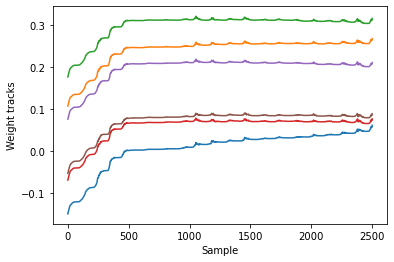

In [2]:
# LMS-MSE for the first training
step_size = 0.01
weight_filter = np.random.normal(0, 0.1, filter_order)

weight_LMS_store = []
LMS_trainMSE_store = []
LMS_testMSE_store = []

LMS_start = time.time()

for i in range (len(signal_x_train_repeat)):
    e_i = signal_y_train_repeat[i] - np.dot(weight_filter, signal_x_train_repeat[i])
    weight_filter = weight_filter + step_size * e_i * signal_x_train_repeat[i]
    weight_LMS_store.append(weight_filter)

LMS_end = time.time()

print('Execution time of LMS-MSE:', LMS_end - LMS_start)

# weight_tracks

l1 = plt.plot(weight_LMS_store)
plt.xlabel('Sample')
plt.ylabel('Weight tracks')
plt.show()

Execution time of LMS-MSE: 0.014003515243530273


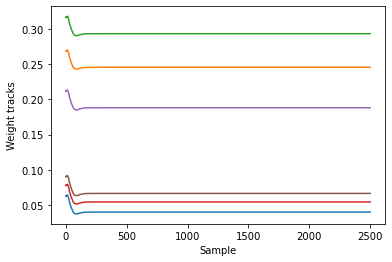

In [3]:
# LMS-MSE for the second training

weight_LMS_traj = []
y_LMS_traj = []
LMS_trainMSE_traj = []
LMS_testMSE_traj = []

LMS_start = time.time()

trajectory_x_train_LMS = signal_x_train[0].copy()
for i in range (len(signal_x_train)):
    filter_output = np.dot(weight_filter, trajectory_x_train_LMS)
    e_i = signal_y_train[i] - filter_output
    weight_filter = weight_filter + step_size * e_i * trajectory_x_train_LMS
    weight_LMS_traj.append(weight_filter)
    trajectory_x_train_LMS = recurrent_system(trajectory_x_train_LMS, filter_output)
    y_LMS_traj.append(filter_output)

LMS_end = time.time()

print('Execution time of LMS-MSE:', LMS_end - LMS_start)

# weight_tracks

l1 = plt.plot(weight_LMS_traj)
plt.xlabel('Sample')
plt.ylabel('Weight tracks')
plt.show()

Execution time of LMS-MCC: 0.01700425148010254


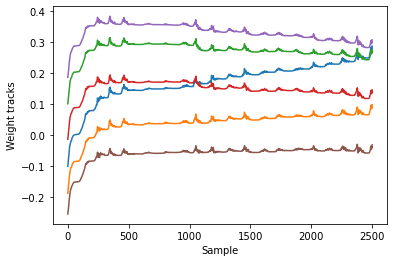

In [4]:
# LMS-MCC for the first training

def kernel_error(x, h):
    return np.exp(-h * x ** 2)

step_size = 0.01
eta = step_size / (0.5 ** 2)
h_error = 1 / (2 * 0.5 **2)
weight_filter = np.random.normal(0, 0.1, filter_order)


weight_MCC_store = []
alpha_MCC_store = []
MCC_trainMSE_store = []
MCC_testMSE_store = []

MCC_start = time.time()

for i in range (len(signal_x_train_repeat)):
    
    e_i = signal_y_train_repeat[i] - np.dot(weight_filter, signal_x_train_repeat[i])
    alpha_MCC_store.append(kernel_error(e_i, h_error) * e_i)
    weight_filter = weight_filter + eta * alpha_MCC_store[i] * signal_x_train_repeat[i]
    weight_MCC_store.append(weight_filter)

MCC_end = time.time()

print('Execution time of LMS-MCC:', MCC_end - MCC_start)

# weight_tracks

l1 = plt.plot(weight_MCC_store)
plt.xlabel('Sample')
plt.ylabel('Weight tracks')
plt.show()

Execution time of LMS-MCC: 0.01906299591064453


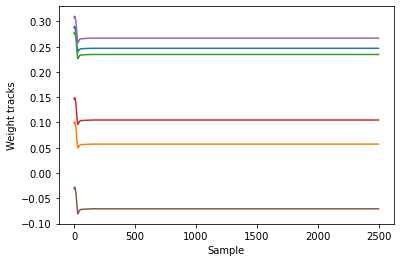

In [5]:
# LMS-MCC for the second training

def kernel_error(x, h):
    return np.exp(-h * x ** 2)

step_size = 0.01
eta = step_size / (0.5 ** 2)
h_error = 1 / (2 * 0.5 **2)


weight_MCC_traj = []
alpha_MCC_traj = []
y_MCC_traj = []
MCC_trainMSE_traj = []
MCC_testMSE_traj = []

MCC_start = time.time()

trajectory_x_train_MCC = signal_x_train[0].copy()
for i in range (len(signal_x_train)):
    filter_output = np.dot(weight_filter, trajectory_x_train_MCC)
    e_i = signal_y_train[i] - filter_output
    alpha_MCC_traj.append(kernel_error(e_i, h_error) * e_i)
    weight_filter = weight_filter + eta * alpha_MCC_traj[i] * trajectory_x_train_MCC
    weight_MCC_traj.append(weight_filter)
    y_MCC_traj.append(filter_output)
    
    trajectory_x_train_MCC = recurrent_system(trajectory_x_train_MCC, filter_output)
    

MCC_end = time.time()

print('Execution time of LMS-MCC:', MCC_end - MCC_start)

# weight_tracks

l1 = plt.plot(weight_MCC_traj)
plt.xlabel('Sample')
plt.ylabel('Weight tracks')
plt.show()

In [6]:
# QKLMS Algorithm for the first training

mu = 0.01 # step size
h_x = 1 / (2 * 1 ** 2) # parameter of Gaussian kernel
delta = 0.05 # quantization threshold

# define kernel
def kernel(x1, x2, h):
    return np.exp(-h * np.sum((x1 - x2) ** 2, axis = 1))


# define QKLMS
QKLMS_center_list = []
QKLMS_alpha_list = []
QKLMS_network_size = []
QKLMS_trainMSE_store = []
QKLMS_testMSE_store = []

QKLMS_start = time.time()

for i in range (len(signal_x_train_repeat)):
    if i == 0:
        filter_output = 0
        QKLMS_alpha_list.append(mu * (signal_y_train_repeat[i] - filter_output))
        QKLMS_center_list.append(signal_x_train_repeat[i])
    else:
        filter_output = np.array(QKLMS_alpha_list) @ kernel(signal_x_train_repeat[i], np.array(QKLMS_center_list), h_x)
        if i <= 1:
            dist_min = np.linalg.norm(signal_x_train_repeat[i] - np.array(QKLMS_center_list))
            dist_min_index = np.argmin(dist_min)
        else:
            dist_store = np.linalg.norm(signal_x_train_repeat[i] - np.array(QKLMS_center_list), axis = 1)
            dist_min_index = np.argmin(dist_store)
            dist_min = min(dist_store)
        if dist_min <= delta:
            QKLMS_alpha_list[dist_min_index] = QKLMS_alpha_list[dist_min_index] + mu * (signal_y_train_repeat[i] - filter_output)
        else:
            QKLMS_alpha_list.append(mu * (signal_y_train_repeat[i] - filter_output))
            QKLMS_center_list.append(signal_x_train_repeat[i])
    QKLMS_network_size.append(len(QKLMS_center_list))

QKLMS_end = time.time()
print('The time of execution using QKLMS:', QKLMS_end - QKLMS_start)

The time of execution using QKLMS: 0.8548388481140137


In [7]:
# QKLMS Algorithm for the second training

mu = 0.01 # step size
h_x = 1 / (2 * 1 ** 2) # parameter of Gaussian kernel
delta = 0.05 # quantization threshold

# define kernel
def kernel(x1, x2, h):
    return np.exp(-h * np.sum((x1 - x2) ** 2, axis = 1))


# define QKLMS
y_QKLMS_traj = []
QKLMS_trainMSE_traj = []
QKLMS_testMSE_traj = []

QKLMS_start = time.time()

trajectory_x_train_QKLMS = signal_x_train[0].copy()
for i in range (len(signal_x_train)):
    filter_output = np.array(QKLMS_alpha_list) @ kernel(trajectory_x_train_QKLMS, np.array(QKLMS_center_list), h_x)
    dist_store = np.linalg.norm(trajectory_x_train_QKLMS - np.array(QKLMS_center_list), axis = 1)
    dist_min_index = np.argmin(dist_store)
    dist_min = min(dist_store)
    if dist_min <= delta:
        QKLMS_alpha_list[dist_min_index] = QKLMS_alpha_list[dist_min_index] + mu * (signal_y_train[i] - filter_output)
    else:
        QKLMS_alpha_list.append(mu * (signal_y_train[i] - filter_output))
        QKLMS_center_list.append(trajectory_x_train_QKLMS)
    
    trajectory_x_train_QKLMS = recurrent_system(trajectory_x_train_QKLMS, filter_output)
    y_QKLMS_traj.append(filter_output)
    QKLMS_network_size.append(len(QKLMS_center_list))

QKLMS_end = time.time()
print('The time of execution using QKLMS:', QKLMS_end - QKLMS_start)

The time of execution using QKLMS: 1.605297327041626


In [8]:
# QKMCC Algorithm for the first training

mu = 0.01 # step size
h_error = 1 / (2 * 0.5 ** 2) # calculate error
h_x = 1 / (2 * 1 ** 2) # calculate y
eta = mu / (0.5 ** 2)
delta = 0.05 # quantization threshold

# define kernel
def kernel(x1, x2, h):
    return np.exp(-h * np.sum((x1 - x2) ** 2, axis = 1))

def kernel_error(x, h):
    return np.exp(-h * x ** 2)


QKMCC_error_store = []
QKMCC_center_list = []
QKMCC_alpha_list = []
QKMCC_trainMSE_store = []
QKMCC_testMSE_store = []
QKMCC_network_size = []

QKMCC_start = time.time()


for i in range (len(signal_x_train_repeat)):
    if i == 0:
        filter_output = 0
        QKMCC_alpha_list.append(mu * (signal_y_train_repeat[i] - filter_output))
        QKMCC_center_list.append(signal_x_train_repeat[i])
    else:
        filter_output = np.array(QKMCC_alpha_list) @ kernel(signal_x_train_repeat[i], np.array(QKMCC_center_list), h_x)
        if i <= 1:
            dist_min = np.linalg.norm(signal_x_train_repeat[i] - np.array(QKMCC_center_list))
            dist_min_index = np.argmin(dist_min)
        else:
            dist_store = np.linalg.norm(signal_x_train_repeat[i] - np.array(QKMCC_center_list), axis = 1)
            dist_min_index = np.argmin(dist_store)
            dist_min = min(dist_store)
        if dist_min <= delta:
            QKMCC_alpha_list[dist_min_index] = QKMCC_alpha_list[dist_min_index] + eta * kernel_error(signal_y_train_repeat[i] - filter_output, h_error) * (signal_y_train_repeat[i] - filter_output)
        else:
            QKMCC_alpha_list.append(eta * kernel_error(signal_y_train_repeat[i] - filter_output, h_error) * (signal_y_train_repeat[i] - filter_output))
            QKMCC_center_list.append(signal_x_train_repeat[i])
    QKMCC_network_size.append(len(QKMCC_center_list))

QKMCC_end = time.time()

print('The time of execution using QKMCC:', QKMCC_end - QKMCC_start)

The time of execution using QKMCC: 0.8527169227600098


In [9]:
# QKMCC Algorithm for the second training

mu = 0.01 # step size
h_error = 1 / (2 * 0.5 ** 2) # calculate error
h_x = 1 / (2 * 1 ** 2) # calculate y
eta = mu / (0.5 ** 2)
delta = 0.05 # quantization threshold

# define kernel
def kernel(x1, x2, h):
    return np.exp(-h * np.sum((x1 - x2) ** 2, axis = 1))

def kernel_error(x, h):
    return np.exp(-h * x ** 2)

y_QKMCC_traj = []
QKMCC_trainMSE_traj = []
QKMCC_testMSE_traj = []

QKMCC_start = time.time()

trajectory_x_train_QKMCC = signal_x_train[0].copy()
for i in range (len(signal_x_train)):
    filter_output = np.array(QKMCC_alpha_list) @ kernel(trajectory_x_train_QKMCC, np.array(QKMCC_center_list), h_x)
    dist_store = np.linalg.norm(trajectory_x_train_QKMCC - np.array(QKMCC_center_list), axis = 1)
    dist_min_index = np.argmin(dist_store)
    dist_min = min(dist_store)
    if dist_min <= delta:
        QKMCC_alpha_list[dist_min_index] = QKMCC_alpha_list[dist_min_index] + eta * kernel_error(signal_y_train[i] - filter_output, h_error) * (signal_y_train[i] - filter_output)
    else:
        QKMCC_alpha_list.append(eta * kernel_error(signal_y_train[i] - filter_output, h_error) * (signal_y_train[i] - filter_output))
        QKMCC_center_list.append(trajectory_x_train_QKMCC)
    
    trajectory_x_train_QKMCC = recurrent_system(trajectory_x_train_QKMCC, filter_output)
    y_QKMCC_traj.append(filter_output)
    QKMCC_network_size.append(len(QKMCC_center_list))

QKMCC_end = time.time()

print('The time of execution using QKMCC:', QKMCC_end - QKMCC_start)

The time of execution using QKMCC: 1.5879409313201904


In [10]:
# QKRLS Algorithm for the first training

lamda = 1
h_x = 1 / (2 * 2 ** 2) # parameter of Gaussian kernel
delta = 0.05 # quantization threshold

# define kernel
def kernel(x1, x2, h):
    return np.exp(-h * np.sum((x1 - x2) ** 2, axis = 1))

# define QKRLS
QKRLS_center_list = [] # h
QKRLS_alpha_list = [] # a
QKRLS_Q_list = [] # Q
QKRLS_network_size = []
QKRLS_trainMSE_store = []
QKRLS_testMSE_store = []
QKRLS_diag_store = []

QKRLS_start = time.time()

for i in range (len(signal_x_train_repeat)):
    if i == 0:
        filter_output = 0
        QKRLS_center_list.append(signal_x_train_repeat[i])
        QKRLS_Q_list.append(1 / (lamda + kernel(signal_x_train_repeat[i], np.array(QKRLS_center_list), h_x)))
        QKRLS_alpha_list.append(QKRLS_Q_list[0] * signal_y_train_repeat[i])
        QKRLS_diag_store.append(np.array([1]))
    else:        
        kernel_h = kernel(signal_x_train_repeat[i], np.array(QKRLS_center_list), h_x)
        filter_output = kernel_h.T @ np.array(QKRLS_alpha_list)
        error = signal_y_train_repeat[i] - filter_output
        if i <= 1:
            dist_min = np.linalg.norm(signal_x_train_repeat[i] - np.array(QKRLS_center_list))
            dist_min_index = np.argmin(dist_min)
        else:
            dist_store = np.linalg.norm(signal_x_train_repeat[i] - np.array(QKRLS_center_list), axis = 1)
            dist_min_index = np.argmin(dist_store)
            dist_min = min(dist_store)
        if dist_min <= delta:
            sign_vector = np.zeros(len(QKRLS_diag_store)).reshape(-1, 1)
            sign_vector[dist_min_index] = 1
            QKRLS_diag_store = QKRLS_diag_store + sign_vector @ sign_vector.T
            kernel_dist_min = kernel(QKRLS_center_list[dist_min_index], np.array(QKRLS_center_list), h_x)
            if len(QKRLS_Q_list) == 1:
                QKRLS_alpha_list = QKRLS_alpha_list + QKRLS_Q_list[dist_min_index].reshape(-1, 1) * (signal_y_train_repeat[i] - kernel_dist_min @ QKRLS_alpha_list) / (1 + kernel_dist_min @ QKRLS_Q_list[dist_min_index])
                QKRLS_Q_list = QKRLS_Q_list - QKRLS_Q_list[dist_min_index].reshape(-1, 1) @ (kernel_dist_min @ QKRLS_Q_list).reshape(1, -1) / (1 + kernel_dist_min @ QKRLS_Q_list[dist_min_index])
            else:
                QKRLS_alpha_list = QKRLS_alpha_list + QKRLS_Q_list[:, dist_min_index].reshape(-1, 1) * (signal_y_train_repeat[i] - kernel_dist_min @ QKRLS_alpha_list) / (1 + kernel_dist_min @ QKRLS_Q_list[:, dist_min_index])
                QKRLS_Q_list = QKRLS_Q_list - QKRLS_Q_list[:, dist_min_index].reshape(-1, 1) @ (kernel_dist_min @ QKRLS_Q_list).reshape(1, -1) / (1 + kernel_dist_min @ QKRLS_Q_list[:, dist_min_index])
        else:
            z = np.array(QKRLS_Q_list).T @ kernel_h
            z_diag = np.array(QKRLS_Q_list) @ QKRLS_diag_store @ kernel_h
            r = lamda + kernel(signal_x_train_repeat[i], np.array([signal_x_train_repeat[i]]), h_x) - z.T @ kernel_h
            QKRLS_Q_list = QKRLS_Q_list + 1 / r * (z_diag.reshape(-1, 1) @ z.reshape(1, -1)) 
            QKRLS_Q_list = np.hstack((QKRLS_Q_list, np.array([- z_diag / r]).T))
            QKRLS_Q_list = np.vstack((QKRLS_Q_list, np.hstack((- 1 / r * z.T, 1 / r))))
            QKRLS_alpha_list = QKRLS_alpha_list - (z_diag * error / r).reshape(-1, 1)
            QKRLS_alpha_list = np.vstack((QKRLS_alpha_list, error / r))
            QKRLS_center_list.append(signal_x_train_repeat[i])
            QKRLS_diag_store = np.hstack((QKRLS_diag_store, np.zeros(len(QKRLS_diag_store)).reshape(-1, 1)))
            QKRLS_diag_store = np.vstack((QKRLS_diag_store, np.hstack((np.zeros(len(QKRLS_diag_store)), 1)).reshape(1, -1)))
    QKRLS_network_size.append(len(QKRLS_center_list))

QKRLS_end = time.time()
print('The time of execution using QKRLS:', QKRLS_end - QKRLS_start)

The time of execution using QKRLS: 60.03989768028259


In [11]:
# QKRLS Algorithm for the second training

lamda = 1
h_x = 1 / (2 * 2 ** 2) # parameter of Gaussian kernel
delta = 0.05 # quantization threshold

# define kernel
def kernel(x1, x2, h):
    return np.exp(-h * np.sum((x1 - x2) ** 2, axis = 1))

# define QKRLS

y_QKRLS_traj = []
QKRLS_trainMSE_traj = []
QKRLS_testMSE_traj = []

QKRLS_start = time.time()
trajectory_x_train_QKRLS = signal_x_train[0].copy()
for i in range (len(signal_x_train)):  
    
    kernel_h = kernel(trajectory_x_train_QKRLS, np.array(QKRLS_center_list), h_x)
    filter_output = kernel_h.T @ np.array(QKRLS_alpha_list)
    error = signal_y_train[i] - filter_output
    dist_store = np.linalg.norm(trajectory_x_train_QKRLS - np.array(QKRLS_center_list), axis = 1)
    dist_min_index = np.argmin(dist_store)
    dist_min = min(dist_store)
    if dist_min <= delta:
        sign_vector = np.zeros(len(QKRLS_diag_store)).reshape(-1, 1)
        sign_vector[dist_min_index] = 1
        QKRLS_diag_store = QKRLS_diag_store + sign_vector @ sign_vector.T
        kernel_dist_min = kernel(QKRLS_center_list[dist_min_index], np.array(QKRLS_center_list), h_x)
        QKRLS_alpha_list = QKRLS_alpha_list + QKRLS_Q_list[:, dist_min_index].reshape(-1, 1) * (signal_y_train[i] - kernel_dist_min @ QKRLS_alpha_list) / (1 + kernel_dist_min @ QKRLS_Q_list[:, dist_min_index])
        QKRLS_Q_list = QKRLS_Q_list - QKRLS_Q_list[:, dist_min_index].reshape(-1, 1) @ (kernel_dist_min @ QKRLS_Q_list).reshape(1, -1) / (1 + kernel_dist_min @ QKRLS_Q_list[:, dist_min_index])
    else:
        z = np.array(QKRLS_Q_list).T @ kernel_h
        z_diag = np.array(QKRLS_Q_list) @ QKRLS_diag_store @ kernel_h
        r = lamda + kernel(trajectory_x_train_QKRLS, np.array([trajectory_x_train_QKRLS]), h_x) - z.T @ kernel_h
        QKRLS_Q_list = QKRLS_Q_list + 1 / r * (z_diag.reshape(-1, 1) @ z.reshape(1, -1)) 
        QKRLS_Q_list = np.hstack((QKRLS_Q_list, np.array([- z_diag / r]).T))
        QKRLS_Q_list = np.vstack((QKRLS_Q_list, np.hstack((- 1 / r * z.T, 1 / r))))
        QKRLS_alpha_list = QKRLS_alpha_list - (z_diag * error / r).reshape(-1, 1)
        QKRLS_alpha_list = np.vstack((QKRLS_alpha_list, error / r))
        QKRLS_center_list.append(trajectory_x_train_QKRLS)
        QKRLS_diag_store = np.hstack((QKRLS_diag_store, np.zeros(len(QKRLS_diag_store)).reshape(-1, 1)))
        QKRLS_diag_store = np.vstack((QKRLS_diag_store, np.hstack((np.zeros(len(QKRLS_diag_store)), 1)).reshape(1, -1)))
    
    trajectory_x_train_QKRLS = recurrent_system(trajectory_x_train_QKRLS, filter_output)
    y_QKRLS_traj.append(filter_output)
    QKRLS_network_size.append(len(QKRLS_center_list))

QKRLS_end = time.time()
print('The time of execution using QKRLS:', QKRLS_end - QKRLS_start)

The time of execution using QKRLS: 62.15097427368164


In [22]:
# QKRGMC Algorithm for the first training

lamda = 1
h_error = 1 / (2 * 0.5 ** 2) # calculate error
h_x = 1 / (2 * 2 ** 2) # calculate y
delta = 0.05 # quantization threshold

# define kernel
def kernel(x1, x2, h):
    return np.exp(-h * np.sum((x1 - x2) ** 2, axis = 1))

def kernel_error(x, h):
    return np.exp(-h * x ** 2)


# define QKRLS
QKRGMC_center_list = [] # h
QKRGMC_alpha_list = [] # a
QKRGMC_Q_list = [] # Q
QKRGMC_G_list = [] # Gaussian error kernel
QKRGMC_network_size = []
QKRGMC_trainMSE_store = []
QKRGMC_testMSE_store = []
QKRGMC_diag_store = []

QKRGMC_start = time.time()

for i in range (len(signal_x_train_repeat)):
    if i == 0:
        filter_output = 0
        QKRGMC_center_list.append(signal_x_train_repeat[i])
        QKRGMC_G_list.append(kernel_error(signal_y_train_repeat[i] - filter_output, h_error))
        QKRGMC_Q_list.append(1 / (lamda * QKRGMC_G_list[0] + kernel(signal_x_train_repeat[i], np.array(QKRGMC_center_list), h_x)))
        QKRGMC_alpha_list.append(QKRGMC_Q_list[0] * signal_y_train_repeat[i])
        QKRGMC_diag_store.append(np.array([1]))
    else:        
        kernel_h = kernel(signal_x_train_repeat[i], np.array(QKRGMC_center_list), h_x)
        filter_output = kernel_h.T @ np.array(QKRGMC_alpha_list)
        error = signal_y_train_repeat[i] - filter_output
        if i <= 1:
            dist_min = np.linalg.norm(signal_x_train_repeat[i] - np.array(QKRGMC_center_list))
            dist_min_index = np.argmin(dist_min)
        else:
            dist_store = np.linalg.norm(signal_x_train_repeat[i] - np.array(QKRGMC_center_list), axis = 1)
            dist_min_index = np.argmin(dist_store)
            dist_min = min(dist_store)
        if dist_min <= delta:
            sign_vector = np.zeros(len(QKRGMC_diag_store)).reshape(-1, 1)
            sign_vector[dist_min_index] = 1
            QKRGMC_diag_store = QKRGMC_diag_store + sign_vector @ sign_vector.T
            kernel_dist_min = kernel(QKRGMC_center_list[dist_min_index], np.array(QKRGMC_center_list), h_x)
            if len(QKRGMC_Q_list) == 1:
                QKRGMC_alpha_list = QKRGMC_alpha_list + QKRGMC_Q_list[dist_min_index].reshape(-1, 1) * (signal_y_train_repeat[i] - kernel_dist_min @ QKRGMC_alpha_list) / (1 + kernel_dist_min @ QKRGMC_Q_list[dist_min_index])
                QKRGMC_Q_list = QKRGMC_Q_list - QKRGMC_Q_list[dist_min_index].reshape(-1, 1) @ (kernel_dist_min @ QKRGMC_Q_list).reshape(1, -1) / (1 + kernel_dist_min @ QKRGMC_Q_list[dist_min_index])
            else:
                QKRGMC_alpha_list = QKRGMC_alpha_list + QKRGMC_Q_list[:, dist_min_index].reshape(-1, 1) * (signal_y_train_repeat[i] - kernel_dist_min @ QKRGMC_alpha_list) / (1 + kernel_dist_min @ QKRGMC_Q_list[:, dist_min_index])
                QKRGMC_Q_list = QKRGMC_Q_list - QKRGMC_Q_list[:, dist_min_index].reshape(-1, 1) @ (kernel_dist_min @ QKRGMC_Q_list).reshape(1, -1) / (1 + kernel_dist_min @ QKRGMC_Q_list[:, dist_min_index])
        else:
            z = np.array(QKRGMC_Q_list).T @ kernel_h
            z_diag = np.array(QKRGMC_Q_list) @ QKRGMC_diag_store @ kernel_h
            r = lamda * QKRGMC_G_list[-1] + kernel(signal_x_train_repeat[i], np.array([signal_x_train_repeat[i]]), h_x) - z.T @ kernel_h
            QKRGMC_Q_list = QKRGMC_Q_list + 1 / r * (z_diag.reshape(-1, 1) @ z.reshape(1, -1)) 
            QKRGMC_Q_list = np.hstack((QKRGMC_Q_list, np.array([- z_diag / r]).T))
            QKRGMC_Q_list = np.vstack((QKRGMC_Q_list, np.hstack((- 1 / r * z.T, 1 / r))))
            QKRGMC_alpha_list = QKRGMC_alpha_list - (z_diag * error / r).reshape(-1, 1)
            QKRGMC_alpha_list = np.vstack((QKRGMC_alpha_list, error / r))
            QKRGMC_center_list.append(signal_x_train_repeat[i])
            QKRGMC_G_list.append(kernel_error(error, h_error))
            QKRGMC_diag_store = np.hstack((QKRGMC_diag_store, np.zeros(len(QKRGMC_diag_store)).reshape(-1, 1)))
            QKRGMC_diag_store = np.vstack((QKRGMC_diag_store, np.hstack((np.zeros(len(QKRGMC_diag_store)), 1)).reshape(1, -1)))
    QKRGMC_network_size.append(len(QKRGMC_center_list))

QKRGMC_end = time.time()
print('The time of execution using QKRGMC:', QKRGMC_end - QKRGMC_start)

The time of execution using QKRGMC: 57.671748638153076


In [23]:
# QKRGMC Algorithm for the second training

lamda = 1
h_error = 1 / (2 * 0.5 ** 2) # calculate error
h_x = 1 / (2 * 2 ** 2) # calculate y
delta = 0.05 # quantization threshold

# define kernel
def kernel(x1, x2, h):
    return np.exp(-h * np.sum((x1 - x2) ** 2, axis = 1))

def kernel_error(x, h):
    return np.exp(-h * x ** 2)


# define QKRLS

y_QKRGMC_traj = []
QKRGMC_trainMSE_traj = []
QKRGMC_testMSE_traj = []

QKRGMC_start = time.time()

trajectory_x_train_QKRGMC = signal_x_train[0].copy()

for i in range (len(signal_x_train)):        
    kernel_h = kernel(trajectory_x_train_QKRGMC, np.array(QKRGMC_center_list), h_x)
    filter_output = kernel_h.T @ np.array(QKRGMC_alpha_list)
    error = signal_y_train[i] - filter_output
    dist_store = np.linalg.norm(trajectory_x_train_QKRGMC - np.array(QKRGMC_center_list), axis = 1)
    dist_min_index = np.argmin(dist_store)
    dist_min = min(dist_store)
    if dist_min <= delta:
        sign_vector = np.zeros(len(QKRGMC_diag_store)).reshape(-1, 1)
        sign_vector[dist_min_index] = 1
        QKRGMC_diag_store = QKRGMC_diag_store + sign_vector @ sign_vector.T
        kernel_dist_min = kernel(QKRGMC_center_list[dist_min_index], np.array(QKRGMC_center_list), h_x)
        QKRGMC_alpha_list = QKRGMC_alpha_list + QKRGMC_Q_list[:, dist_min_index].reshape(-1, 1) * (signal_y_train[i] - kernel_dist_min @ QKRGMC_alpha_list) / (1 + kernel_dist_min @ QKRGMC_Q_list[:, dist_min_index])
        QKRGMC_Q_list = QKRGMC_Q_list - QKRGMC_Q_list[:, dist_min_index].reshape(-1, 1) @ (kernel_dist_min @ QKRGMC_Q_list).reshape(1, -1) / (1 + kernel_dist_min @ QKRGMC_Q_list[:, dist_min_index])
    else:
        z = np.array(QKRGMC_Q_list).T @ kernel_h
        z_diag = np.array(QKRGMC_Q_list) @ QKRGMC_diag_store @ kernel_h
        r = lamda * QKRGMC_G_list[-1] + kernel(trajectory_x_train_QKRGMC, np.array([trajectory_x_train_QKRGMC]), h_x) - z.T @ kernel_h
        QKRGMC_Q_list = QKRGMC_Q_list + 1 / r * (z_diag.reshape(-1, 1) @ z.reshape(1, -1)) 
        QKRGMC_Q_list = np.hstack((QKRGMC_Q_list, np.array([- z_diag / r]).T))
        QKRGMC_Q_list = np.vstack((QKRGMC_Q_list, np.hstack((- 1 / r * z.T, 1 / r))))
        QKRGMC_alpha_list = QKRGMC_alpha_list - (z_diag * error / r).reshape(-1, 1)
        QKRGMC_alpha_list = np.vstack((QKRGMC_alpha_list, error / r))
        QKRGMC_center_list.append(trajectory_x_train_QKRGMC)
        QKRGMC_G_list.append(kernel_error(error, h_error))
        QKRGMC_diag_store = np.hstack((QKRGMC_diag_store, np.zeros(len(QKRGMC_diag_store)).reshape(-1, 1)))
        QKRGMC_diag_store = np.vstack((QKRGMC_diag_store, np.hstack((np.zeros(len(QKRGMC_diag_store)), 1)).reshape(1, -1)))
    trajectory_x_train_QKRGMC = recurrent_system(trajectory_x_train_QKRGMC, filter_output)
    y_QKRGMC_traj.append(filter_output)
    QKRGMC_network_size.append(len(QKRGMC_center_list))

QKRGMC_end = time.time()
print('The time of execution using QKRGMC:', QKRGMC_end - QKRGMC_start)

The time of execution using QKRGMC: 61.07173442840576


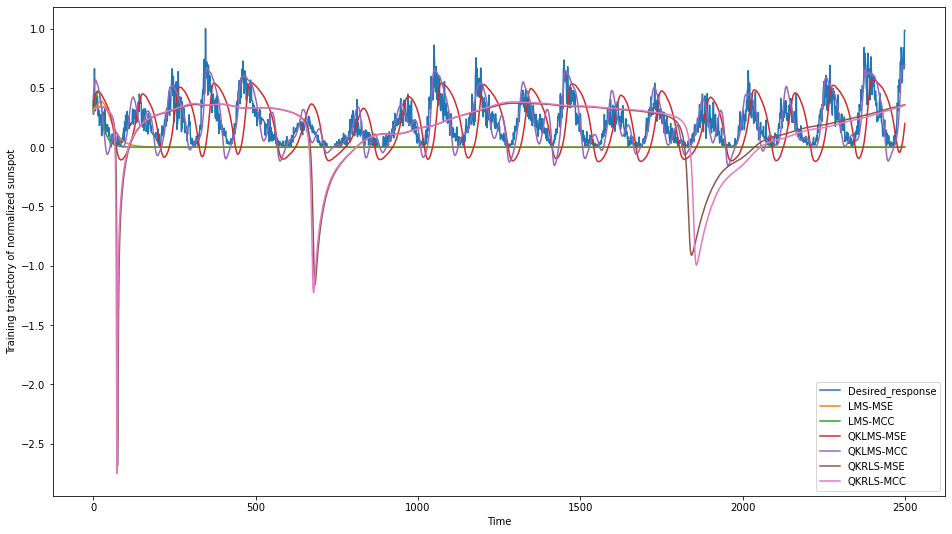

In [24]:
fig = plt.figure(figsize = (16, 9))
l1 = plt.plot(signal_y_train)
l2 = plt.plot(np.array(y_LMS_traj))
l3 = plt.plot(np.array(y_MCC_traj))
l4 = plt.plot(np.array(y_QKLMS_traj))
l5 = plt.plot(np.array(y_QKMCC_traj))
l6 = plt.plot(np.array(y_QKRLS_traj))
l7 = plt.plot(np.array(y_QKRGMC_traj))
plt.xlabel('Time')
plt.ylabel('Training trajectory of normalized sunspot')
plt.legend(['Desired_response', 'LMS-MSE', 'LMS-MCC', 'QKLMS-MSE', 'QKLMS-MCC', 'QKRLS-MSE', 'QKRLS-MCC'])
plt.show()

In [15]:
## =================================================== Q1 AND Q2 ======================================================##

In [16]:
# Learning the trajectory
def recurrent_system(x, y):
    for i in range (1, len(x)):
        x[-i] = x[-i-1]
    x[0] = y
    return x

trajectory_y_LMS = []
trajectory_y_MCC = []
trajectory_y_QKLMS = []
trajectory_y_QKMCC = []
trajectory_y_QKRLS = []
trajectory_y_QKRGMC = []
trajcetory_y_desired = []

trajectory_x = signal_x_test[0]
trajectory_x_LMS = trajectory_x.copy()
trajectory_x_MCC = trajectory_x.copy()
trajectory_x_QKLMS = trajectory_x.copy()
trajectory_x_QKMCC = trajectory_x.copy()
trajectory_x_QKRLS = trajectory_x.copy()
trajectory_x_QKRGMC = trajectory_x.copy()
for nnn in range (len(signal_y_test)):
    y_LMS = np.dot(weight_LMS_traj[-1], trajectory_x_LMS)
    trajectory_y_LMS.append(y_LMS)
    y_MCC = np.dot(weight_MCC_traj[-1], trajectory_x_MCC)
    trajectory_y_MCC.append(y_MCC)
    y_QKLMS = np.array(QKLMS_alpha_list) @ kernel(trajectory_x_QKLMS, np.array(QKLMS_center_list), h_x)
    trajectory_y_QKLMS.append(y_QKLMS)
    y_QKMCC = np.array(QKMCC_alpha_list) @ kernel(trajectory_x_QKMCC, np.array(QKMCC_center_list), h_x)
    trajectory_y_QKMCC.append(y_QKMCC)
    y_QKRLS = kernel(trajectory_x_QKRLS, np.array(QKRLS_center_list), h_x).T @ np.array(QKRLS_alpha_list)
    trajectory_y_QKRLS.append(y_QKRLS[0])
    y_QKRGMC = kernel(trajectory_x_QKRGMC, np.array(QKRGMC_center_list), h_x).T @ np.array(QKRGMC_alpha_list)
    trajectory_y_QKRGMC.append(y_QKRGMC[0])
    trajectory_x_LMS = recurrent_system(trajectory_x_LMS, y_LMS)
    trajectory_x_MCC = recurrent_system(trajectory_x_MCC, y_MCC)
    trajectory_x_QKLMS = recurrent_system(trajectory_x_QKLMS, y_QKLMS)
    trajectory_x_QKMCC = recurrent_system(trajectory_x_QKMCC, y_QKMCC)
    trajectory_x_QKRLS = recurrent_system(trajectory_x_QKRLS, y_QKRLS[0])
    trajectory_x_QKRGMC = recurrent_system(trajectory_x_QKRGMC, y_QKRGMC[0])

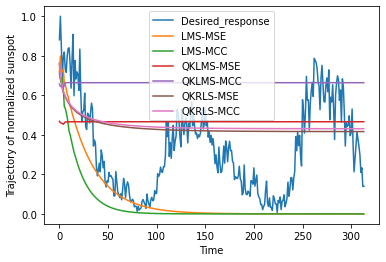

In [17]:
l1 = plt.plot(signal_y_test)
l2 = plt.plot(np.array(trajectory_y_LMS))
l3 = plt.plot(np.array(trajectory_y_MCC))
l4 = plt.plot(np.array(trajectory_y_QKLMS))
l5 = plt.plot(np.array(trajectory_y_QKMCC))
l6 = plt.plot(np.array(trajectory_y_QKRLS))
l7 = plt.plot(np.array(trajectory_y_QKRGMC))
plt.xlabel('Time')
plt.ylabel('Trajectory of normalized sunspot')
plt.legend(['Desired_response', 'LMS-MSE', 'LMS-MCC', 'QKLMS-MSE', 'QKLMS-MCC', 'QKRLS-MSE', 'QKRLS-MCC'])
plt.show()

In [18]:
for jji in range (len(signal_y_test)):
    if abs(trajectory_y_LMS[jji] - signal_y_test[jji]) > error_threshold:
        break
print('count_LMS:', jji)
for jji in range (len(signal_y_test)):
    if abs(trajectory_y_MCC[jji] - signal_y_test[jji]) > error_threshold:
        break
print('count_LMS:', jji)
for jji in range (len(signal_y_test)):
    if abs(trajectory_y_QKLMS[jji] - signal_y_test[jji]) > error_threshold:
        break
print('count_LMS:', jji)
for jji in range (len(signal_y_test)):
    if abs(trajectory_y_QKMCC[jji] - signal_y_test[jji]) > error_threshold:
        break
print('count_LMS:', jji)
for jji in range (len(signal_y_test)):
    if abs(trajectory_y_QKRLS[jji] - signal_y_test[jji]) > error_threshold:
        break
print('count_LMS:', jji)
for jji in range (len(signal_y_test)):
    if abs(trajectory_y_QKRGMC[jji] - signal_y_test[jji]) > error_threshold:
        break
print('count_LMS:', jji)   

count_LMS: 14
count_LMS: 1
count_LMS: 0
count_LMS: 1
count_LMS: 1
count_LMS: 1
